<a href="https://colab.research.google.com/github/Bikash9841/Image_Background_Replacer/blob/main/ImageBackgroundReplacement_usingSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

background removal of original image to replace with another scenary image.
1. replace background with the custom image.
2. replace background with AI generated image based on prompt.

Note: dont load the image file before deploying the function in the `modelbit` API



# Install diffusers and other

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

#Install Segment-Anything

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-b2by3uj4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-b2by3uj4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=d0ebc3276b5bced544e281cc167fdd968093f4dfa9e67b37547b6afd0a3ae567
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fc869ya/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


#Install modelbit to deploy ML model to the cloud `Runtime restart required.`

In [ ]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: build
    Found existing installation: build 1.0.3
    Uninstalling build-1.0.3:
      Successfully u

#Downloading model checkpoint and Creating a `SAM` model.

In [ ]:
from segment_anything import SamPredictor,sam_model_registry
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from google.colab.patches import cv2_imshow


model_path='./sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)

#Downloading a `test_img`

In [ ]:
import requests
import os
import cv2 as cv

# URL of the image(sherlock)
image_url = "https://i.pinimg.com/originals/f3/87/e1/f387e11f493953e9ed3b4be72c96cced.jpg"

# (dog)
# image_url = "https://images.ctfassets.net/j4x7ugudy4uu/4N0RDxHUz31uhaXYS24cth/eaf00f8620a1899713def55eb9f1245d/sc_carousel_0_2x.jpg"

# man in a canoe
# image_url ="https://minneapolis2040.com/media/1115/goal11_cleanenvironment_womancanoeing.jpg"

# Specify the local filename
local_filename = "test_img.jpg"

if not os.path.exists(f'./{local_filename}'):

  print(f'---downloading image from the url: {image_url}')
  # Download the image
  response = requests.get(image_url)

  # Save the image with the specified filename
  with open(local_filename, 'wb') as file:
      file.write(response.content)

  print(f"Image downloaded and saved as {local_filename}")

img=cv.imread(f'./{local_filename}')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img,cmap='gray')
plt.axis('off')

In [ ]:
#use sam predictor on image to get the location of subject

x,y=300,300

predictor.set_image(img)
mask,_,_=predictor.predict(point_coords=np.asarray([[x,y]]),
                           point_labels=np.asarray([1]),
                           multimask_output=True)
print(mask.dtype)

bool


(3, 668, 668)


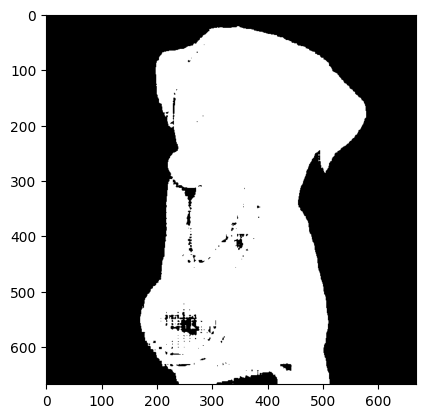

In [ ]:
print(mask.shape)

C,H,W=mask.shape
result_mask=np.zeros((H,W),dtype=bool)
# plt.imshow(result_mask,cmap='gray')
for j in range(C):
  result_mask |= mask[j, :, :]

result_mask = result_mask.astype(np.uint8)

plt.imshow(result_mask,cmap="gray")

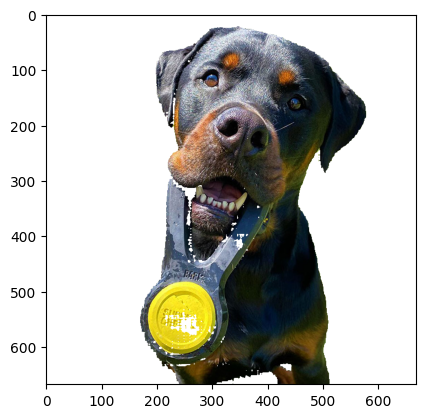

In [ ]:
# remove background
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0
result_image = cv.merge((img, alpha_channel))

plt.imshow(result_image)

#FunctionTo_`remove_background`

In [ ]:
import base64
import cv2 as cv

def remove_background(image_base64_encoding,x,y):

  # decoding the b64 encoded image into numpy array format
  image_bytes = base64.b64decode(image_base64_encoding)
  image = cv.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv.IMREAD_COLOR)

  predictor.set_image(image)
  mask,_,_=predictor.predict(point_coords=np.asarray([[x,y]]),
                          point_labels=np.asarray([1]),
                          multimask_output=True)

  C,H,W=mask.shape
  result_mask=np.zeros((H,W),dtype=bool)

  for j in range(C):
    result_mask |= mask[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  # remove background
  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255
  alpha_channel[result_mask == 0] = 0
  result_image = cv.merge((image, alpha_channel))

  # encoding the image into b64 format
  _, result_image_bytes = cv.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64




#Modelbit- Making an API

In [ ]:
import modelbit
mb = modelbit.login()

In [ ]:
mb.deploy(remove_background)

Uploading 'predictor': 100%|██████████| 348M/348M [00:11<00:00, 29.9MB/s]


# testing `remove_background` function

In [ ]:

# encoding image in base64 format
img=cv.imread('test_img.jpg')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

_, img_bytes = cv.imencode('.png',img)
img_bytes= img_bytes.tobytes()
image_bytes_encoded = base64.b64encode(img_bytes).decode('utf-8')

# sending the encoded image in `remove_background` function
final_image=remove_background(image_bytes_encoded,x,y)

# decoding the received encoded image from the function into simple numpy array
final_image_bytes = base64.b64decode(final_image)
final_image = cv.imdecode(np.frombuffer(final_image_bytes, dtype=np.uint8), cv.IMREAD_UNCHANGED)


<class 'numpy.ndarray'>


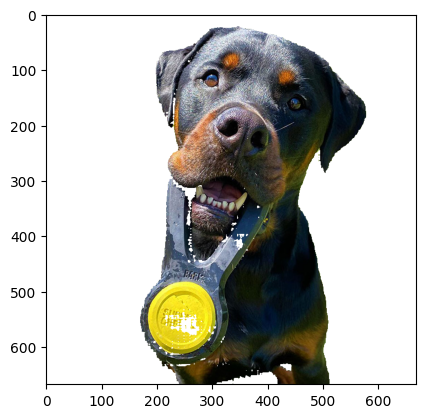

In [ ]:
# final_image=cv.cvtColor(final_image, cv.COLOR_BGR2RGB)
print(type(final_image))
plt.imshow(final_image)
# plt.show()

#Image Background Removal-Calling from the API
-You dont need to install SAM, modelbit. You directly call those functionality using API made earlier.

In [4]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import requests

# URL of the image(sherlock)
image_url = "https://i.pinimg.com/originals/f3/87/e1/f387e11f493953e9ed3b4be72c96cced.jpg"

# (dog)
# image_url = "https://images.ctfassets.net/j4x7ugudy4uu/4N0RDxHUz31uhaXYS24cth/eaf00f8620a1899713def55eb9f1245d/sc_carousel_0_2x.jpg"

# man in a canoe
# image_url ="https://minneapolis2040.com/media/1115/goal11_cleanenvironment_womancanoeing.jpg"


# Specify the local filename
local_filename = "test_img.jpg"

if not os.path.exists(f'./{local_filename}'):

  print(f'---downloading image from the url: {image_url}')
  # Download the image
  response = requests.get(image_url)

  # Save the image with the specified filename
  with open(local_filename, 'wb') as file:
      file.write(response.content)

  print(f"Image downloaded and saved as {local_filename}")


x,y=1000,3000
api_endpoint_br ="https://rituramojha.ap-south-1.modelbit.com/v1/remove_background/latest"

# encoding image
img=cv.imread(local_filename)
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

_, img_bytes = cv.imencode('.png',img)
img_bytes= img_bytes.tobytes()
image_bytes_encoded = base64.b64encode(img_bytes).decode('utf-8')

# calling from the api
api_data = {"data": [image_bytes_encoded, x, y]}
response = requests.post(api_endpoint_br, json=api_data)

final_image = response.json()['data']

# decoding the received encoded image from the function into simple numpy array
final_image_bytes = base64.b64decode(final_image)
final_image_api = cv.imdecode(np.frombuffer(final_image_bytes, dtype=np.uint8), cv.IMREAD_UNCHANGED)


---downloading image from the url: https://i.pinimg.com/originals/f3/87/e1/f387e11f493953e9ed3b4be72c96cced.jpg
Image downloaded and saved as test_img.jpg


0


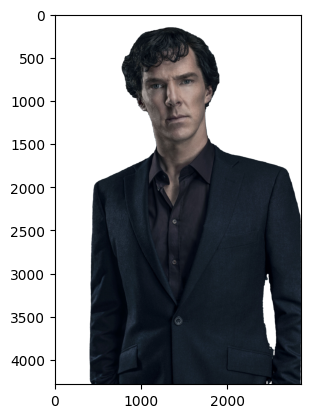

In [5]:

plt.imshow(final_image_api)
print(final_image_api[300,300,3])

# Downloading a new image and add it as a background

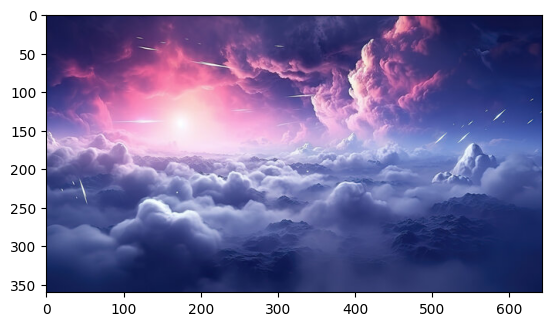

In [ ]:
url="https://t4.ftcdn.net/jpg/06/27/00/35/360_F_627003529_WLNIRaYMNDQawZW11LCdzX6SFaZrULJt.jpg"

# Specify the local filename
bg_img = "bg_img.jpg"

if not os.path.exists(f'./{bg_img}'):

  print(f'---downloading image from the url: {url}')
  # Download the image
  response = requests.get(url)

  # Save the image with the specified filename
  with open(bg_img, 'wb') as file:
      file.write(response.content)

  print(f"Image downloaded and saved as {bg_img}")

bg_img=cv.imread(bg_img)
bg_img=cv.cvtColor(bg_img,cv.COLOR_BGR2RGB)
plt.imshow(bg_img)


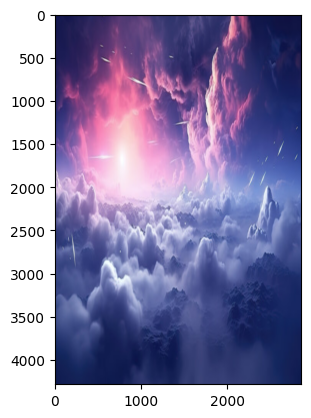

In [ ]:
bg_img=cv.resize(bg_img,(final_image_api.shape[1],final_image_api.shape[0]))
plt.imshow(bg_img)

orig A: 0 not A: 255
255


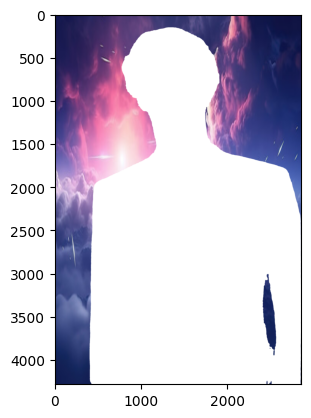

In [ ]:
x=final_image_api[:,:,3]
y = cv.bitwise_not(x)

# 0 opaque, 255 full transparent
print(f'orig A: {x[0,0]} not A: {y[0,0]}')
n=cv.merge((bg_img,y))
print(n[0,0,3])
plt.imshow(n)

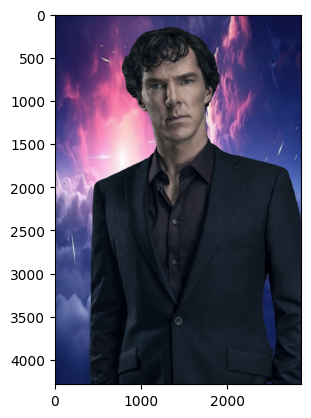

In [ ]:
for i in range(bg_img.shape[0]):
  for j in range(bg_img.shape[1]):
    if n[i,j,3]==0:
      n[i,j]=final_image_api[i,j]

plt.imshow(n)

In [ ]:
print(n.shape)

(668, 668, 4)


# Text-Image Generation Using Stable Diffusion
calling API from modelbit

In [16]:
import requests
import numpy as np
import cv2 as cv
import base64
import matplotlib.pyplot as plt

api_endpoint_ig="https://rituramojha.ap-south-1.modelbit.com/v1/generate_image/latest"

prompt="photo realistic murder scene background"

# calling from the api
api_data = {"data": [prompt]}
response = requests.post(api_endpoint_ig, json=api_data)

# print(response.json())
final_image = response.json()['data']

# decoding the received encoded image from the function into simple numpy array
final_image_bytes = base64.b64decode(final_image)
gen_img_api = cv.imdecode(np.frombuffer(final_image_bytes, dtype=np.uint8), cv.IMREAD_UNCHANGED)


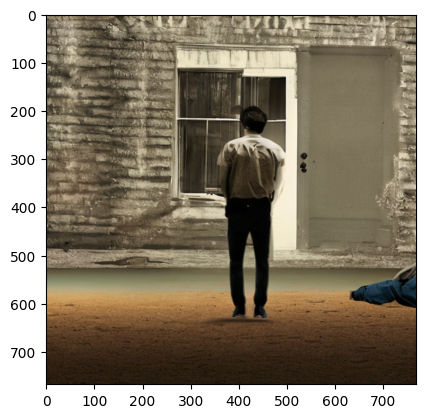

In [17]:
plt.imshow(gen_img_api)

# Replacing the background with generated image

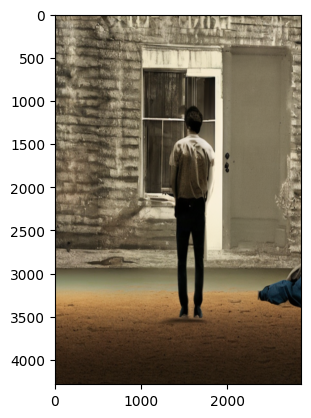

In [18]:
bg_img=cv.resize(gen_img_api,(final_image_api.shape[1],final_image_api.shape[0]))
plt.imshow(bg_img)

orig A: 0 not A: 255
255


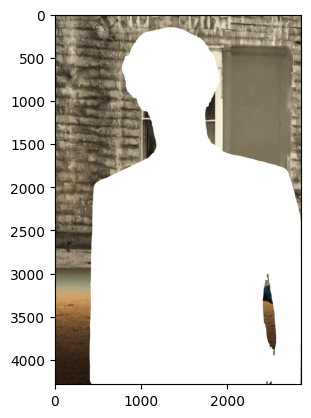

In [19]:
x=final_image_api[:,:,3]
y = cv.bitwise_not(x)

# 0 opaque, 255 full transparent
print(f'orig A: {x[0,0]} not A: {y[0,0]}')
n=cv.merge((bg_img,y))
print(n[0,0,3])
plt.imshow(n)

(-0.5, 2855.5, 4283.5, -0.5)

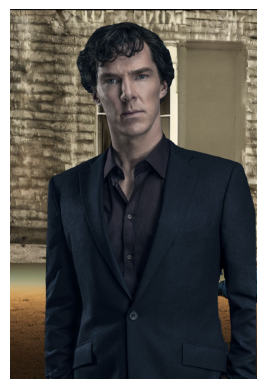

In [20]:
# for i in range(bg_img.shape[0]):
#   for j in range(bg_img.shape[1]):
#     if n[i,j,3]==0:
#       n[i,j]=final_image_api[i,j]

# Create a mask for pixels where the alpha channel of n is 0
alpha_zero_mask = n[:, :, 3] == 0

# Use the mask to update the values in n with the corresponding values from final_image_api
n[alpha_zero_mask] = final_image_api[alpha_zero_mask]

plt.imshow(n)
plt.axis("off")